In [1]:
from IPython.core.interactiveshell import InteractiveShell as IS
IS.ast_node_interactivity = "all"
import sys
from utils.tools import load_obj, save_obj
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm

In [2]:
def iewt1d(ewt, mfb):
    # 转化为原始信号
    real = all(np.isreal(ewt[0]))
    if real:
        rec = np.zeros(len(ewt[0]))
        for i in range(0,len(ewt)):
            rec += np.real(np.fft.ifft(np.fft.fft(ewt[i])*mfb[i]))
    else:
        rec = np.zeros(len(ewt[0]))*0j
        for i in range(0,len(ewt)):
            rec += np.fft.ifft(np.fft.fft(ewt[i])*mfb[i])
    return rec

In [3]:
def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))
def metircs(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    mape = MAPE(pred, true)
    return {"rmse":rmse, "r2":r2, "mape":mape}

## 数据加载

In [4]:
TARGET = "53ea38cpu"
cols = [TARGET]
N = 3

df = pd.read_csv(f"./data/{TARGET}.csv", index_col=[0], parse_dates=True)
df.head()
metrics_dict = {}

,53ea38cpu,53ea38cpu0,53ea38cpu1,53ea38cpu2,53ea38cpu0_mfb,53ea38cpu1_mfb,53ea38cpu2_mfb
timestamp,,,,,,,
2014-02-14 14:30:00,1.732,1.781859,-0.039888,-0.021626,1.0,0.0,0.0
2014-02-14 14:35:00,1.732,1.776982,0.021464,-0.062150,1.0,0.0,0.0
2014-02-14 14:40:00,1.960,1.773595,0.067309,0.107154,1.0,0.0,0.0
2014-02-14 14:45:00,1.732,1.772693,0.030049,-0.062049,1.0,0.0,0.0
2014-02-14 14:50:00,1.706,1.774818,-0.060227,-0.020501,1.0,0.0,0.0


## lstm-ewt 预测

In [5]:
seq_len, pred_len = 80, 1
total_len = len(df)
model_name = "lstmewt"

In [6]:
# 不同horizon下的分量预测结果
lstmewt_horizon_dict = {}
for hn in range(1, 21):
    # 加载不同horizon下的各分量预测结果
    pred_lst = []
    # true_lst = []
    for i in range(N):
        true, pred = load_obj(f"./results/google1/lstm_google1_ftS_sl{seq_len}_ll0_pl{pred_len}_is1_os1_hn{hn}_bs32_lr0.001_{TARGET}{i}_0/true_pred.pkl")
        # true_lst.append(true)
        pred_lst.append(pred)
    pred_lstm = np.concatenate(pred_lst,axis=-1)
    # true_lstm = np.concatenate(true_lst, axis=-1)
    lstmewt_horizon_dict[hn] = pred_lstm

In [7]:
target_horizon = 1
lstmewt_metrics = {}
# 记录所有horizon下test_data的结果，用于计算整体metrics
trues_test_lst, preds_test_lst = [], []
for horizon in range(1, 21):
    out_len = max(pred_len, horizon)
    gap = horizon - 1
    length = total_len - seq_len - out_len + 1
    test_size = int(length*0.2)
    cut_point = length - test_size
    pred_startpoint = cut_point + seq_len + gap

    pre_len = seq_len + gap
    for col in cols:
        tmp_mfb = df[[f"{col}{i}_mfb" for i in range(N)]].values
        # seq_len部分的ewt
        pre_ewt = df.iloc[:pre_len][[f"{col}{i}" for i in range(N)]]
        # 和预测得到的ewt组合
        pred_horizon = lstmewt_horizon_dict[horizon][:,0,:]
        # pred_horizon = pred_lstm[:,target_horizon-1,:]]
        ewt_pred = np.concatenate([pre_ewt, pred_horizon], axis=0)
        # 重构
        reconstruction = iewt1d(ewt_pred.T, tmp_mfb.T)
        target = df[col]
        # 预测评估
        trues_test = target.values[pred_startpoint:]
        preds_test = reconstruction[pred_startpoint:]
        trues_test_lst.append(trues_test)
        preds_test_lst.append(preds_test)
        
        lstmewt_metrics[f"horizon{horizon}"] = metircs(trues_test, preds_test)
    if horizon == target_horizon:
        lstmewt_target_horizon_data = [target, reconstruction, ewt_pred]
trues_test_all, preds_test_all = np.concatenate(trues_test_lst),  np.concatenate(preds_test_lst)
lstmewt_metrics["allhorizon"] = metircs(trues_test_all, preds_test_all)
metrics_dict["lstmewt"] = pd.DataFrame(lstmewt_metrics).T

In [8]:
metrics_dict["lstmewt"]

,rmse,r2,mape
horizon1,0.068680,0.501963,0.027285
horizon2,0.081322,0.301753,0.033738
horizon3,0.071733,0.456707,0.028932
horizon4,0.072943,0.438023,0.029298
horizon5,0.068998,0.497167,0.026919
horizon6,0.072004,0.452398,0.027897
horizon7,0.076878,0.375754,0.029976
horizon8,0.086761,0.204940,0.035008
horizon9,0.076423,0.383576,0.029665
horizon10,0.080650,0.313495,0.031949


### target_horizon展示

In [9]:
target, reconstruction, ewt_pred = lstmewt_target_horizon_data
gap = target_horizon - 1

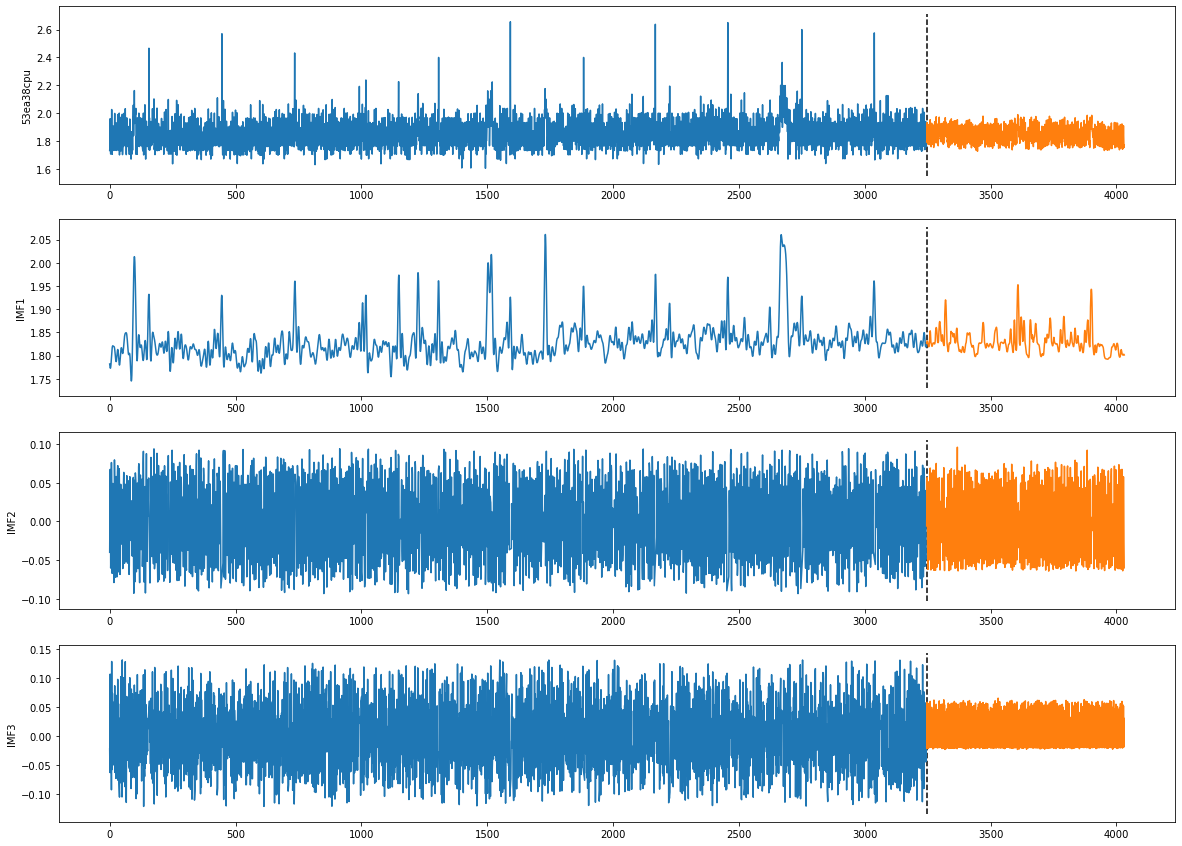

In [10]:
for col in cols:
    fig = plt.figure(figsize=(20, 15))
    _ = plt.subplot(N+1, 1, 1)
    _ = plt.plot(range(pred_startpoint-gap), target.values[:pred_startpoint-gap])
    _ = plt.plot(range(pred_startpoint, len(df)), reconstruction[pred_startpoint:])
    ax = plt.gca()
    _ = plt.vlines(pred_startpoint-gap, ax.get_ylim()[0], ax.get_ylim()[1], ls='--')
    _ = plt.ylabel(f"{col}");
    for i in range(N):
        _ = plt.subplot(N+1, 1, i+2)
        _ = plt.plot(range(pred_startpoint-gap), df[f"{col}{i}"][:pred_startpoint-gap], )
          
        _ = plt.plot(range(pred_startpoint, len(df)), ewt_pred[:, i][pred_startpoint:])
        ax = plt.gca()
        _ = plt.vlines(pred_startpoint, ax.get_ylim()[0], ax.get_ylim()[1], ls='--')
        _ = plt.ylabel(f"IMF{i+1}");

In [11]:
fig.savefig(f"./savefig/{TARGET}_{model_name}ewt0.png")

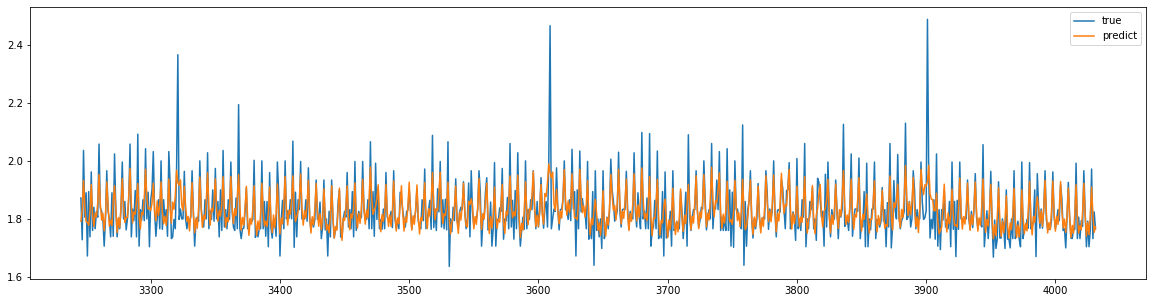

In [12]:
fig = plt.figure(figsize=(20, 5))
plt.plot(range(pred_startpoint, len(df)), target.values[pred_startpoint:], label="true")
plt.plot(range(pred_startpoint, len(df)), reconstruction[pred_startpoint:], label="predict")
plt.legend();

In [13]:
fig.savefig(f"./savefig/{TARGET}_{model_name}ewt1.png")

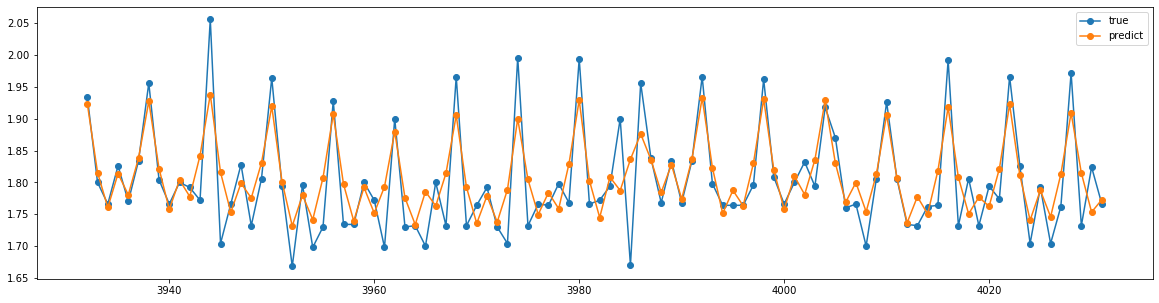

In [14]:
fig = plt.figure(figsize=(20, 5))
select_length = 100
plt.plot(range(len(df)-select_length, len(df)), target.values[-select_length:], '-o', label="true")
plt.plot(range(len(df)-select_length, len(df)), reconstruction[-select_length:], '-o', label="predict")
plt.legend();

In [15]:
fig.savefig(f"./savefig/{TARGET}_{model_name}ewt2.png")

## lstm 预测

In [16]:
seq_len, pred_len = 80, 1
total_len = len(df)

In [17]:
lstm_horizon_dict = {}
for hn in range(1, 21):
    true, pred = load_obj(f"./results/google1/lstm_google1_ftS_sl{seq_len}_ll0_pl{pred_len}_is1_os1_hn{hn}_bs32_lr0.001_{TARGET}_0/true_pred.pkl")
    lstm_horizon_dict[hn] = pred

In [18]:
target_horizon = 1
lstm_metrics = {}
# 记录所有horizon下test_data的结果，用于计算整体metrics
trues_test_lst, preds_test_lst = [], []
for horizon in range(1, 21):
    out_len = max(pred_len, horizon)
    gap = horizon - 1
    length = total_len - seq_len - out_len + 1
    test_size = int(length*0.2)
    cut_point = length - test_size
    pred_startpoint = cut_point + seq_len + gap

    pre_len = seq_len + gap
    for col in cols:
        # seq_len部分的col
        pre_col = df.iloc[:pre_len][[col]]
        # 和预测得到的col组合
        pred_horizon = lstm_horizon_dict[horizon][:,0,:]
        pred_horizon = np.concatenate([pre_col, pred_horizon], axis=0)
        target = df[col]
        # 预测评估
        trues_test = target.values[pred_startpoint:]
        preds_test = pred_horizon[pred_startpoint:]
        trues_test_lst.append(trues_test)
        preds_test_lst.append(preds_test.flatten())
        
        lstm_metrics[f"horizon{horizon}"] = metircs(trues_test, preds_test)
    if horizon == target_horizon:
        lstm_target_horizon_data = [target, pred_horizon]
    
trues_test_all, preds_test_all = np.concatenate(trues_test_lst), np.concatenate(preds_test_lst)
lstm_metrics["allhorizon"] = metircs(trues_test_all, preds_test_all)
metrics_dict["lstm"] = pd.DataFrame(lstm_metrics).T

In [19]:
metrics_dict["lstm"]

,rmse,r2,mape
horizon1,0.097725,-0.008353,0.037479
horizon2,0.097468,-0.003040,0.037815
horizon3,0.069839,0.485013,0.046533
horizon4,0.070386,0.476741,0.045640
horizon5,0.068492,0.504518,0.045709
horizon6,0.066703,0.530058,0.045767
horizon7,0.066645,0.530876,0.044478
horizon8,0.069163,0.494757,0.047963
horizon9,0.068558,0.503923,0.046495
horizon10,0.069215,0.494365,0.045130


## former-ewt 预测

In [20]:
seq_len, label_len, pred_len = 80, 10, 20
total_len = len(df)
target_horizon_data_dict = {}
target_horizon = 1

In [21]:
for model_name in ["auto", "in", "trans"]:
    # 读取数据
    ewt_pred_lst = []
    for i in range(N):
        true_, pred_ = load_obj(f"./results/google1/{model_name}former_google1_ftS_sl{seq_len}_ll{label_len}_pl{pred_len}_is1_os1_hn1_bs32_lr0.0001_{TARGET}{i}_0/true_pred.pkl")
        ewt_pred_lst.append(pred_)
    model_ewt_pred = np.concatenate(ewt_pred_lst,axis=-1)    
    
    ewt_metrics = {}
    # 记录所有horizon下test_data的结果，用于计算整体metrics
    trues_test_lst, preds_test_lst = [], []
    for horizon in range(1, 21):
        out_len = max(pred_len, horizon)
        gap = horizon - 1
        length = total_len - seq_len - out_len + 1
        test_size = int(length*0.2)
        cut_point = length - test_size
        pred_startpoint = cut_point + seq_len + gap

        pre_len = seq_len + gap
        for col in cols:
            # former多步预测时，截断了最后horizon个步长，为了对齐，要截断
            align_len = pred_len-horizon
            align_len = -total_len if align_len<=0 else align_len
            tmp_mfb = df[[f"{col}{i}_mfb" for i in range(N)]].values[:-align_len]
            # seq_len部分的ewt
            pre_ewt = df.iloc[:pre_len][[f"{col}{i}" for i in range(N)]]
            # 和预测得到的ewt组合
            pred_horizon = model_ewt_pred[:,horizon-1,:]
            ewt_pred = np.concatenate([pre_ewt, pred_horizon], axis=0)
            # 重构
            reconstruction = iewt1d(ewt_pred.T, tmp_mfb.T)
            target = df[col][:-align_len]
            # 预测评估
            trues_test = target.values[pred_startpoint:]
            preds_test = reconstruction[pred_startpoint:]
            trues_test_lst.append(trues_test)
            preds_test_lst.append(preds_test)

            ewt_metrics[f"horizon{horizon}"] = metircs(trues_test, preds_test)
        if horizon == target_horizon:
            ewt_target_horizon_data = [target, reconstruction, ewt_pred]
            target_horizon_data_dict[model_name+"ewt"] = ewt_target_horizon_data
            
    trues_test_all, preds_test_all = np.concatenate(trues_test_lst),  np.concatenate(preds_test_lst)
    ewt_metrics["allhorizon"] = metircs(trues_test_all, preds_test_all)
    metrics_dict[f"{model_name}ewt"] = pd.DataFrame(ewt_metrics).T

In [22]:
metrics_dict[f"{model_name}ewt"]

,rmse,r2,mape
horizon1,0.061595,0.598574,0.022865
horizon2,0.068460,0.504701,0.026825
horizon3,0.072614,0.443063,0.028502
horizon4,0.070951,0.467896,0.027293
horizon5,0.073694,0.424773,0.028544
horizon6,0.074573,0.411676,0.028823
horizon7,0.076556,0.379937,0.029681
horizon8,0.079231,0.336321,0.031531
horizon9,0.077606,0.363309,0.030419
horizon10,0.076032,0.388788,0.029392


### target_horizon展示

In [23]:
show_model = "auto"
target, reconstruction, ewt_pred = target_horizon_data_dict[show_model+"ewt"]
gap = target_horizon-1

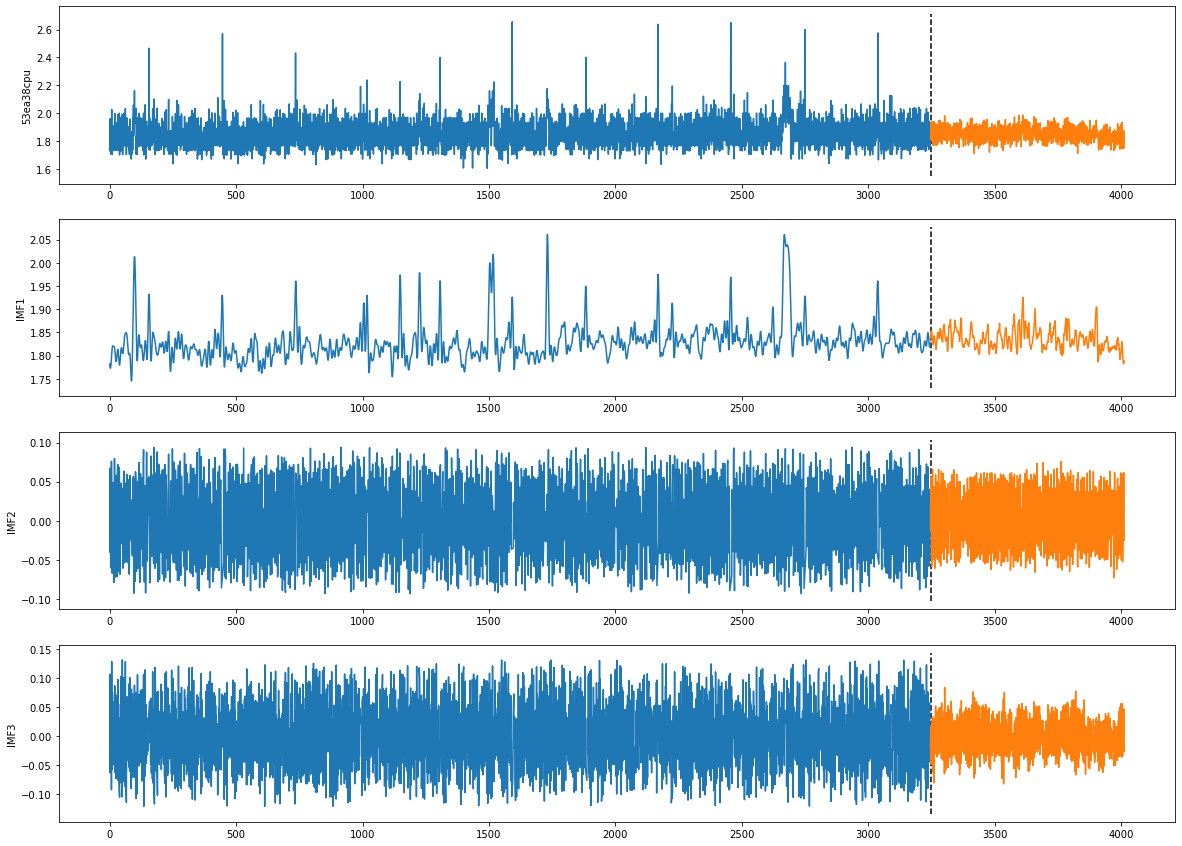

In [24]:
for col in cols:
    fig = plt.figure(figsize=(20, 15))
    _ = plt.subplot(N+1, 1, 1)
    _ = plt.plot(range(pred_startpoint-gap), target.values[:pred_startpoint-gap])
    _ = plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), reconstruction[pred_startpoint:])
    ax = plt.gca()
    _ = plt.vlines(pred_startpoint-gap, ax.get_ylim()[0], ax.get_ylim()[1], ls='--')
    _ = plt.ylabel(f"{col}");
    for i in range(N):
        _ = plt.subplot(N+1, 1, i+2)
        _ = plt.plot(range(pred_startpoint-gap), df[f"{col}{i}"][:pred_startpoint-gap], )
          
        _ = plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), ewt_pred[:, i][pred_startpoint:])
        ax = plt.gca()
        _ = plt.vlines(pred_startpoint, ax.get_ylim()[0], ax.get_ylim()[1], ls='--')
        _ = plt.ylabel(f"IMF{i+1}");

In [25]:
fig.savefig(f"./savefig/{TARGET}_{model_name}ewt0.png")

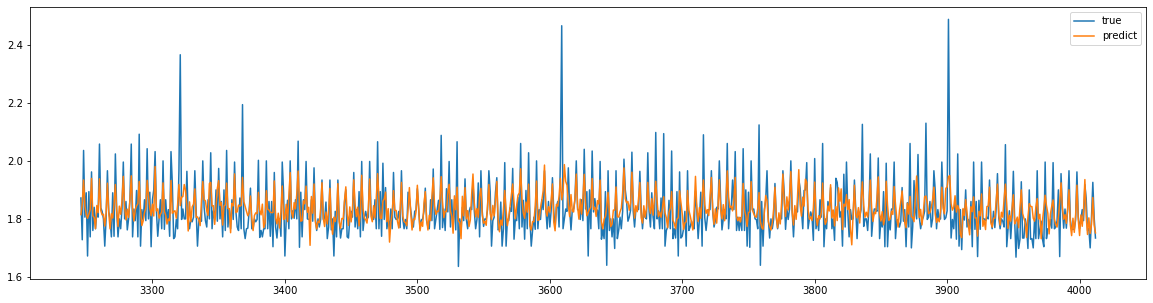

In [26]:
fig = plt.figure(figsize=(20, 5))
plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), target.values[pred_startpoint:], label="true")
plt.plot(range(pred_startpoint, len(df)-pred_len+target_horizon), reconstruction[pred_startpoint:], label="predict")
plt.legend();

In [27]:
fig.savefig(f"./savefig/{TARGET}_{model_name}ewt1.png")

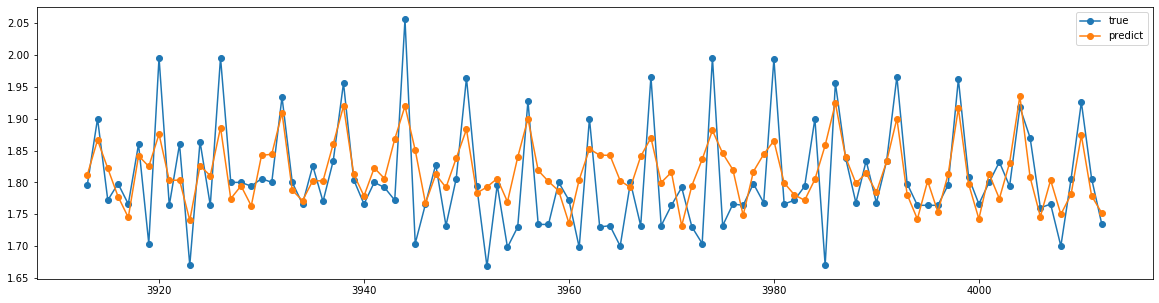

In [28]:
fig = plt.figure(figsize=(20, 5))
select_length = 100
plt.plot(range(len(df)-pred_len+target_horizon-select_length, len(df)-pred_len+target_horizon), target.values[-select_length:], '-o', label="true")
plt.plot(range(len(df)-pred_len+target_horizon-select_length, len(df)-pred_len+target_horizon), reconstruction[-select_length:], '-o', label="predict")
plt.legend();

In [29]:
fig.savefig(f"./savefig/{TARGET}_{model_name}ewt2.png")

## former预测

In [30]:
seq_len, label_len, pred_len = 80, 10, 20
total_len = len(df)
target_horizon = 1

In [31]:
for model_name in ["auto", "in", "trans"]:
    _true, _pred = load_obj(f"./results/google1/{model_name}former_google1_ftS_sl{seq_len}_ll{label_len}_pl{pred_len}_is1_os1_hn1_bs32_lr0.0001_{TARGET}_0/true_pred.pkl")

    _metrics = {}
    # 记录所有horizon下test_data的结果，用于计算整体metrics
    trues_test_lst, preds_test_lst = [], []
    for horizon in range(1, 21):
        out_len = max(pred_len, horizon)
        gap = horizon - 1
        length = total_len - seq_len - out_len + 1
        test_size = int(length*0.2)
        cut_point = length - test_size
        pred_startpoint = cut_point + seq_len + gap

        pre_len = seq_len + gap
        for col in cols:
            align_len = pred_len-horizon
            align_len = -total_len if align_len<=0 else align_len
            # seq_len部分的col
            pre_col = df.iloc[:pre_len][[col]]
            # 和预测得到的col组合
            pred_horizon = _pred[:,horizon-1,:]
            pred_horizon = np.concatenate([pre_col, pred_horizon], axis=0)
            target = df[col][:-align_len]
            # 预测评估
            trues_test = target.values[pred_startpoint:]
            preds_test = pred_horizon[pred_startpoint:]
            trues_test_lst.append(trues_test)
            preds_test_lst.append(preds_test.flatten())

            _metrics[f"horizon{horizon}"] = metircs(trues_test, preds_test)
        if horizon == target_horizon:
            _target_horizon_data = [target, pred_horizon]

    trues_test_all, preds_test_all = np.concatenate(trues_test_lst),  np.concatenate(preds_test_lst)
    _metrics["allhorizon"] = metircs(trues_test_all, preds_test_all)
    metrics_dict[f"{model_name}"] = pd.DataFrame(_metrics).T

In [32]:
metrics_dict[f"{model_name}"]

,rmse,r2,mape
horizon1,0.066991,0.525154,0.049575
horizon2,0.069652,0.487289,0.048837
horizon3,0.070685,0.472255,0.048939
horizon4,0.075544,0.396785,0.044722
horizon5,0.072622,0.441394,0.043861
horizon6,0.070665,0.471726,0.048363
horizon7,0.069922,0.482735,0.048665
horizon8,0.070310,0.477352,0.046550
horizon9,0.073064,0.435655,0.048665
horizon10,0.072911,0.437945,0.048578


## arima rolling

In [33]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA,ARIMA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [34]:
def get_result(val_data, test_data, rolling=True, pred_len=20, seq_len=200):
    history = [x for x in val_data[-seq_len:, 0]]

    preds_lst = list()
    trues_lst = list()
    initial = True
    for t in tqdm(range(len(test_data[:, 0])-pred_len)):
        history = history[-seq_len:]
        if initial:
            model = ARMA(history, order=(5, 0, 0))
            try:
                model_fit = model.fit()
            except:
                model_fit = model.fit(start_params=model_fit.params)
                
            # 仅估计一次模型，否则，滚动预测，迭代feed数据，重新估计模型
            if not rolling:
                initial = False
            
        output = model_fit.forecast(pred_len)
        yhat = output[0]
        preds_lst.append(yhat)
        obs = test_data[:, 0][t]
        history.append(obs)
        trues_lst.append(test_data[:, 0][t:t+pred_len])
    return preds_lst, trues_lst

In [35]:
val_size = int(len(df)*0.1)
test_size = int(len(df)*0.2)
ar_data = df[cols].values
train_data, val_data, test_data \
    = ar_data[:(len(df)-test_size-val_size)], ar_data[(len(df)-test_size-val_size):(len(df)-test_size)], ar_data[-test_size:]

In [36]:
# arma_model=ARMA(train_data[:, 0], order=(5, 0, 0))
# arma_result=arma_model.fit()
# arma_result.summary()

In [37]:
preds_lst, trues_lst = get_result(val_data, test_data, rolling=True)

  0%|          | 0/786 [00:00<?, ?it/s]

E:\ANACONDA\Lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [38]:
ar_preds = np.stack(preds_lst, axis=0)
ar_trues = np.stack(trues_lst, axis=0)

ar_metrics = {}
for horizon in range(1, 21):
    ar_metrics[f"horizon{horizon}"] = metircs(ar_trues[:, horizon-1], ar_preds[:, horizon-1])
ar_metrics["allhorizon"] = metircs(ar_trues.flatten(), ar_preds.flatten())
metrics_dict["arima_rolling"] = pd.DataFrame(ar_metrics).T

In [39]:
metrics_dict["arima_rolling"]

,rmse,r2,mape
horizon1,0.093647,0.072297,0.036677
horizon2,0.090707,0.129441,0.035933
horizon3,0.089693,0.149817,0.035448
horizon4,0.089289,0.157911,0.034988
horizon5,0.089105,0.160777,0.034852
horizon6,0.089157,0.158065,0.034600
horizon7,0.096298,0.018960,0.037714
horizon8,0.096291,0.019037,0.037778
horizon9,0.096207,0.021449,0.037762
horizon10,0.096132,0.023045,0.037865


## arima static

In [40]:
preds_lst, trues_lst = get_result(val_data, test_data, rolling=False)

  0%|          | 0/786 [00:00<?, ?it/s]

E:\ANACONDA\Lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [41]:
ar_preds = np.stack(preds_lst, axis=0)
ar_trues = np.stack(trues_lst, axis=0)

ar_metrics = {}
for horizon in range(1, 21):
    ar_metrics[f"horizon{horizon}"] = metircs(ar_trues[:, horizon-1], ar_preds[:, horizon-1])
ar_metrics["allhorizon"] = metircs(ar_trues.flatten(), ar_preds.flatten())
metrics_dict["arima_static"] = pd.DataFrame(ar_metrics).T

In [42]:
metrics_dict["arima_static"]

,rmse,r2,mape
horizon1,0.099286,-0.042782,0.035761
horizon2,0.097431,-0.004417,0.036891
horizon3,0.098851,-0.032667,0.036008
horizon4,0.100843,-0.074121,0.035367
horizon5,0.098015,-0.015452,0.040505
horizon6,0.098903,-0.036077,0.042066
horizon7,0.097736,-0.010557,0.039969
horizon8,0.097473,-0.005185,0.039241
horizon9,0.097393,-0.002823,0.038824
horizon10,0.097279,-0.000408,0.037487


## 模型评估

In [43]:
def evaluation_show(taget_indictor, target_horizon, sort=True):
    hist_dict = {}
    for key, value in metrics_dict.items():
        hist_dict[key] = value[taget_indictor][target_horizon]
    if sort:
        hist_dict = dict(sorted(hist_dict.items(), key=lambda x:x[1]))
    fig = plt.figure(figsize=(10, 6))
    x, width = 0, 0.25
    xtick_lst = []
    xlabel_lst = []
    for key, value in hist_dict.items():
        xtick_lst.append(x)
        xlabel_lst.append(key)
        plt.bar(x, value, width=width, label=key)
        x += width
    plt.xticks(xtick_lst, xlabel_lst)
    plt.title(f"{taget_indictor}_{target_horizon}")
    plt.legend();
    return fig, hist_dict

In [50]:
target_horizon = "horizon1"

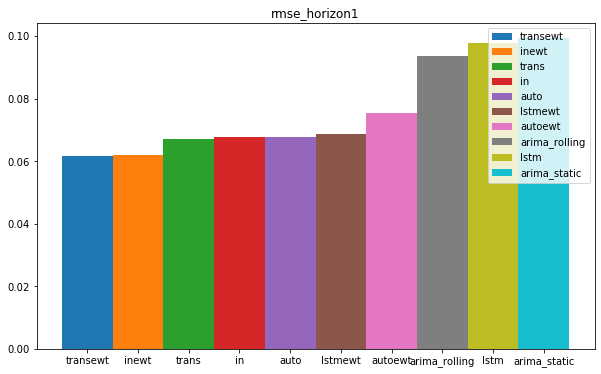

In [51]:
taget_indictor = 'rmse'
fig, hist_dict = evaluation_show(taget_indictor, target_horizon)

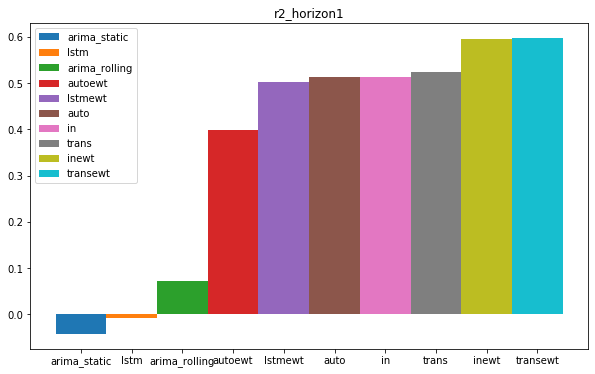

In [52]:
taget_indictor = 'r2'
fig, hist_dict = evaluation_show(taget_indictor, target_horizon)

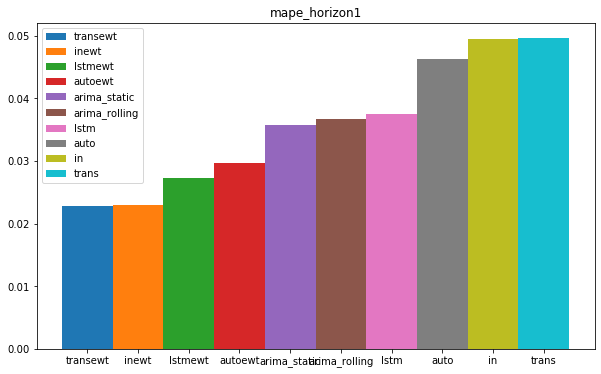

In [53]:
taget_indictor = 'mape'
fig, hist_dict = evaluation_show(taget_indictor, target_horizon)

### save_metrics

In [54]:
save_metrics = {}
for key, value in metrics_dict.items():
    save_metrics[key] = metrics_dict[key].loc[target_horizon, :].to_dict()

In [55]:
pd.DataFrame(save_metrics).T

,rmse,r2,mape
lstmewt,0.068680,0.501963,0.027285
lstm,0.097725,-0.008353,0.037479
autoewt,0.075393,0.398582,0.029670
inewt,0.061839,0.595391,0.023000
transewt,0.061595,0.598574,0.022865
auto,0.067847,0.512947,0.046214
in,0.067753,0.514302,0.049526
trans,0.066991,0.525154,0.049575
arima_rolling,0.093647,0.072297,0.036677
arima_static,0.099286,-0.042782,0.035761
